In [1]:
import pandas as pd
import requests
import numpy as np
from sklearn.linear_model import LinearRegression 
from datetime import timedelta
from datetime import datetime
import io
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from scipy.stats import t
from outliers import smirnov_grubbs as grubbs
from scipy.optimize import curve_fit
import statistics
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
import math
from scipy.signal import convolve
from scipy.interpolate import interp1d
from filterpy.kalman import KalmanFilter
import numpy as np
pd.options.mode.chained_assignment = None
from itertools import combinations 
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib notebook

In [78]:
def import_database(wifi = 0):
    #Import database
#     url = "http://btserver-lab10.polito.it/conn_info?csv=1&wifi="+str(wifi)
#     url = "https://drive.google.com/open?id=1A80LjH4X1amgVUBx5Pqqa4BsO92jzII3"
#     s = requests.get(url).content

#     df1 = pd.read_csv(io.StringIO(s.decode('utf-8')), sep=",")
    df1 = pd.read_csv("/home/hugo/Documentos/HumanToHuman/jupyter-experiments/experiment_bt_22_05_2019.csv", sep=",")
    
    if(wifi == 0):
        #Set up the array 
        df1.columns = ['ID1','ID2','MAC2','rssi','ismobile','timestamp','milliseconds']
        df1['timestamp'] = pd.to_datetime(df1['timestamp'])
        df1.loc[df1.ID1 == '607217d83721d6b95a426d9ecab7573b','ID1'] = '03d2fad7913f3ee053f5e5cdd3617268'
        df1.loc[df1.ID2 == '607217d83721d6b95a426d9ecab7573b','ID2'] = '03d2fad7913f3ee053f5e5cdd3617268' 
        
    else:
        df1.columns = ['ID1','bssid','rssi','timestamp','milliseconds']
        df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    return df1
            
def load_json_experiments(number):
    #Load Json Data
    with open('robot_exp.json') as json_data:
        experiments = json.load(json_data)
    experiment = experiments['experiments'][number]
    start_date = experiment['start_date']
    end_date = experiment['end_date']
    interval = experiment['interval']
    positions = experiment['pos']
    return start_date,end_date,interval,positions
def get_x_y_from_pos(pos):
    with open('robot_exp.json') as json_data:
        experiments = json.load(json_data)
    positions = experiments['positions']
    for real_pos in positions:
        if pos == real_pos['pos']:
            return real_pos['distance']['x'],real_pos['distance']['y']
    return None,None
def get_device_name(device_id):
    with open('robot_exp.json') as json_data:
        experiments = json.load(json_data)
    devices = experiments['devices']
    for real_id in devices:
        if device_id == real_id['id']:
            return real_id['name']
def get_id_robot(n):   
    start_date,end_date,interval,pos = load_json_experiments(n)
    for k,v in pos.items():
        if k == 'robot':
            return v
            break
def get_device_pos(pos,device):
    position = ""
    for k,v in pos.items():
        if v == device['id']:
            position = k
            break
    x,y = get_x_y_from_pos(position)
    return x,y,(position == 'robot')
            
def get_allowed_tuples(n):
    with open('robot_exp.json') as json_data:
        experiments = json.load(json_data)
    exp_pos = experiments['experiments'][n]['pos']
    robot_device = exp_pos['robot']
    tuples = []
    for index, (key,value) in enumerate(exp_pos.items()):
        if key == 'robot':
            continue
        tuples.append([robot_device,value])
    return tuples
def load_json_devices():
    with open('robot_exp.json') as json_data:
        experiments = json.load(json_data)
    return experiments['devices']

In [79]:

def weighted_moving_average_filter(data,factor = 3):
    data = data.sort_values('milliseconds')
    ref_t = factor * 5
    lenght = data.shape[0]
    final_vals = []
    for i in range(lenght):
        current_milli = data.iloc[i]['milliseconds']
        max_m = current_milli + (ref_t)
        min_m = current_milli - (ref_t)
        vals = data[data.milliseconds >= min_m]
        vals = vals[vals.milliseconds <= max_m]
        av_vals = pd.DataFrame()
#         current_val = rssi
        for j in range(vals.shape[0]):
            rssi = vals.iloc[j]['rssi']
            weight = cal_weight(ref_t,current_milli,vals.iloc[j]['milliseconds'])
            av_vals = av_vals.append([{'rssi' : rssi, 'weight' : weight}])
        av_vals = norm_weight(av_vals)
        final_vals.append(get_rssi_from_weight(av_vals))
        
    data.loc[:,'rssi_filtered'] = final_vals
    return data
        
def cal_ref_t(data):
    return np.mean(obtain_dif_from_data(data))
def obtain_dif_from_data(data):
    millis = data['milliseconds'].tolist()
    len_millis = len(millis) - 1
    diffs = []
    for i in range(len_millis):
        dif = np.abs(np.diff([millis[i],millis[i+1]]))
        if dif < 1.5 * 60 * 1000: 
            diffs.append(dif)
    return diffs
def cal_weight(ref_t,current_t,t):
    if current_t != t :
        current_dif = np.diff([t,current_t])
        current_dif = -np.abs(current_dif/ref_t)
    else:
        current_dif = -0
    return math.exp(current_dif)

def norm_weight(values):
1    weights = values.weight.values
    total_sum = np.sum(weights)
    norm_weights = []
    for weight in weights:
        norm_weights.append(weight/total_sum)
    values.loc[:,'norm_weight'] =norm_weights
    return values
def get_rssi_from_weight(data):
    l = np.multiply(data.rssi.values,data.norm_weight.values)
    l = np.sum(l)
    return l



In [191]:
def filter_data(data,fil=None,factor = 3):
    if fil == None:
        data.loc[:,'rssi_filtered'] = data['rssi']
        return data
    
    return fil(data,factor = factor)
def handle_data(data,start_date,end_date,device1,device2=None,f = None,factor = 3):
    start = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    end = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
    #Process all the data 
    data = data.drop_duplicates()
    treated_data = data[(data.timestamp >= (start)) & ((data.timestamp) <=(end))]
    treated_data = treated_data[(treated_data.ID1 == device1)]
    treated_data = treated_data[(treated_data.rssi <= -30)]
    treated_data = treated_data[(treated_data.rssi >= -120)]
    if device2 != None:
        treated_data = treated_data[(treated_data.ID2 == device2)]
    if treated_data.shape[0] <=2: return pd.DataFrame()
    return filter_data(treated_data,f,factor = factor)
def add_real_pos(data,pos,device):
    x,y,is_robot = get_device_pos(pos,device)
    d_data = data[data.ID1 == device['id']]
    d_data = d_data.sort_values('milliseconds')
    new_df = pd.DataFrame()
    if not is_robot:
        t_data = d_data
        lenght = t_data.shape[0]
        t_data.loc[:,'x'] = np.full(lenght,x)
        t_data.loc[:,'y'] = np.full(lenght,y)
        t_data.loc[:,'is_robot'] = np.full(lenght,0)
        new_df = new_df.append(t_data)
    else:
        #calculate pos:
        milliseconds = data['milliseconds'].tolist()
        start = min(milliseconds)
        end = max(milliseconds)
        interval = 60 * 1000
        distance = 4
        interval_distance = 0.5
        distance_it = int(distance/interval_distance) + 1
        repeat_it = math.ceil((end-start) / (interval * distance_it))
        max_duration = distance_it * interval 
        
        for repeat in range(repeat_it):
            for distance in range(distance_it):
                real_distance = distance * interval_distance
                start_time = start + interval * distance + repeat * max_duration
                end_time = start_time + interval
                t_data = d_data[(d_data.milliseconds >= start_time) & (d_data.milliseconds < end_time)]
                lenght = t_data.shape[0]
                t_data.loc[:,'x'] = np.full(lenght,x + real_distance)
                t_data.loc[:,'y'] = np.full(lenght,y)
                t_data.loc[:,'is_robot'] = np.full(lenght,1)
 
                new_df = new_df.append(t_data)
    return new_df
                
                
def add_devices_positions(data,pos,start_date,end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    end = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
    #Process all the data 
    data = data[(data.timestamp >= (start)) & ((data.timestamp) <=(end))]
    new_df = pd.DataFrame()
    for device in load_json_devices():
        new_df = new_df.append(add_real_pos(data,pos,device))
    return new_df

def add_devices_real_distances(data,pos,start_date,end_date,exp):
    start = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    end = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
    #Process all the data 
    data = data[(data.timestamp >= (start)) & ((data.timestamp) <=(end))]
    new_df = pd.DataFrame()
    for device in load_json_devices():
        if device == get_id_robot(exp): continue
        new_df = new_df.append(add_distance_from_device_to_robot(data,pos,device))
    return new_df


    
def add_distance_from_device_to_robot(data,pos,device):
    x,y,is_robot = get_device_pos(pos,device)
    d_data = data[data.ID1 == device['id']]
    d_data = d_data.sort_values('milliseconds')
    new_df = pd.DataFrame()
    robot_data = data[data.is_robot == True]
    if not is_robot:
        milliseconds = data['milliseconds'].tolist()
        start = min(milliseconds)
        end = max(milliseconds)
        interval = 60 * 1000
        distance = 4
        interval_distance = 0.5
        distance_it = int(distance/interval_distance) + 1
        repeat_it = math.ceil((end-start) / (interval * distance_it))
        max_duration = distance_it * interval
        for repeat in range(repeat_it):
                for distance in range(distance_it):
                    start_time = start + interval * distance + repeat * max_duration
                    end_time = start_time + interval
                    t_data = d_data[(d_data.milliseconds >= start_time) & (d_data.milliseconds < end_time)]
                    r_data = robot_data[(robot_data.milliseconds >= start_time) & (robot_data.milliseconds < end_time)]
                    if t_data.shape[0] == 0 or r_data.shape[0] == 0:
                        continue
                    x2,y2 = r_data.x.unique(),r_data.y.unique()
                    lenght = t_data.shape[0]
                    dis = get_distance(x,x2,y,y2)
                    t_data.loc[:,'distance'] = np.full(lenght,dis)
                    new_df = new_df.append(t_data)
    else:
        robot_data.loc[:,'distance'] = np.full(robot_data.shape[0],0) 
        new_df = new_df.append(robot_data) 
    return new_df
def is_under_close_distance(data,rssi = 'rssi_filtered'):
    data = data.sort_values(rssi)
    q3 =np.percentile(data[rssi],[75])[0]
    return q3

def add_calculated_distance_by_one_device(data,device,rssi = 'rssi_filtered'):
    a,n = calculate_fit_vals(data)
    print("Device " + get_device_name(device),a,n)
    print(a,n)
    cal_dist = (cal_distance_by_rssi(data,a,n))
    data.loc[:,'calculated_distance'] = cal_dist
    return data
def add_calculated_distance_by_two_devices(data,device,robot,rssi="rssi_filtered"):
    mean_dif = cal_ref_t(data)
   
    
    min_milli = min(data.milliseconds.values)
    max_milli = max(data.milliseconds.values)
    
    iterations = math.ceil((max_milli - min_milli) / mean_dif)
    new_df = pd.DataFrame()
    for i in range(iterations):
        start = min_milli + i * mean_dif
        end = start + mean_dif
        
        t_data = data[(data.milliseconds >= start) & (data.milliseconds < end)]
        t1 = t_data[t_data.ID1 == device]
        t2 = t_data[t_data.ID1 == robot]
        
        if t1.shape[0] == 0 or t2.shape[0] == 0:
            continue
        d1 = np.mean(t1.calculated_distance.values)
        d2 = np.mean(t2.calculated_distance.values)
        final_mean = np.mean([d1,d2])
        
        t_data.loc[:,'mean_distance'] = np.full(t_data.shape[0],final_mean)
        new_df = new_df.append(t_data)
    return new_df
        
def cal_distance_by_rssi(data,a,n,rssi_f = 'rssi_filtered'):
    l=[]
    if data.shape[0] == 0: return l
    for rssi in data[rssi_f].tolist():
        l.append(distance_by_rssi(rssi,a,n))
    return l
    
def calculate_fit_vals(data,rssi='rssi_filtered'):
    #From the data, we take the third quartile as the rssi at 1 meter, if the value is under -65 dbs
    ref_param = is_under_close_distance(data)
    data = data[(data[rssi] < ref_param +10) & (data[rssi] > ref_param)]
#     print(np.mean(data[rssi].values))
    if ref_param <= -65:
        ref_param == 65
        return ref_param,2
    else:
        return ref_param,path_loss_exp(np.mean(data[rssi].values),ref_param,d = 0.85)

def calculate_fit_vals(data,rssi='rssi_filtered'):
    #From the data, we take the third quartile as the rssi at 1 meter, if the value is under -65 dbs
    ref_param = is_under_close_distance(data)
    data = data[(data[rssi] < ref_param +10) & (data[rssi] > ref_param)]
#     print(np.mean(data[rssi].values))
    if ref_param <= -65:
        ref_param == 65
        return ref_param,2
    else:
        return ref_param,path_loss_exp(np.mean(data[rssi].values),ref_param,d = 0.85)

        
def path_loss_exp(x,a,d=0.5):
    return (a-x) / (10*np.log10(d))

def distance_by_rssi(x,a,n):
    return np.power(10,-(x-a)/(10*n))
                
def get_distance(x1,x2,y1,y2):
    a = math.pow((x1-x2),2)
    b = math.pow((y1-y2),2)
    return math.sqrt(a+b)

In [182]:
def plot_rssi_by_time(data1,data2,device1,device2,interval):
    if data1.shape[0] <= 15 :
        return
    if data2.shape[0] <= 15:
        return 
    millis1 = data1['milliseconds'].tolist()
    millis2 = data2['milliseconds'].tolist()
    millis1 = np.subtract(millis1,min(millis1))  
    millis2 = np.subtract(millis2,min(millis2))
    max_milli = max([max(millis1),max(millis2)])
    plt.figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.title("RSSI by time")
    plt.xlabel('date')
    plt.ylabel('dbm')
    interval = interval * 1000
    n_lines = math.ceil(max_milli/interval)
    axes = plt.gca()
    name1 = get_device_name(device1)
    name2 = get_device_name(device2)
    p1 = plt.scatter(millis1,data1['rssi_filtered'],label=(name2 + " seen by " + name1))
    p2 = plt.scatter(millis2,data2['rssi_filtered'],label=(name1 + " seen by " + name2))
    for n in range(0,n_lines+1):
        plt.axvline(x=n*interval, color='k', linestyle='--')
    plt.legend(loc = 'best')
    plt.show()

def plot_rssi_by_distance(data,device,robot):
    data = data[(data.ID1 == device) & (data.ID2 == robot)]
    plt.figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.title("RSSI by distance")
    plt.xlabel('distance')
    plt.ylabel('dbm')
    name1 = get_device_name(device)
    name2 = get_device_name(robot)
    p1 = plt.scatter(data['distance'],data['rssi_filtered'],label=(name2 + " seen by " + name1))
    plt.legend(loc = 'best')
    plt.show()

def plot_custom_distance_by_time(data,device,n,interval = 10,rssi = 'rssi_filtered'):
    robot = get_id_robot(n)
    if robot == device: return
    new_data = add_calculated_distance(data,device,robot)
    millis = new_data['milliseconds'].tolist()
    millis = np.subtract(millis,min(millis))
    name1 = get_device_name(device)
    name2 = get_device_name(robot)
    plt.figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.gca()
    ax.get_xaxis().get_major_formatter().set_scientific(False)
    plt.title("Distance by Time")
    plt.ylabel('distance')
    plt.xlabel('milliseconds')
    plt.ticklabel_format(useOffset=False)
    p1 = plt.scatter(millis,new_data['mean_distance'],\
                     label=("Distance between "+ name2 + " and " + name1))
    plt.legend(loc = 'best')
    plt.show()
    
    

In [183]:
dataBT = import_database()

In [7]:
#Main information of the experiment:
data = pd.DataFrame()
i = 0
#Histogram of how much time differences between two samples of a device
while True:
    try:
        start_date,end_date,interval,positions = load_json_experiments(i)
    except:
        break
    for device in load_json_devices():
        data = data.append(handle_data(dataBT,start_date,end_date,device['id']))
    i = i+1
mean_dif1 = []
for device in load_json_devices():
        mean_dif1.extend(obtain_dif_from_data(data[data.ID1 == device['id']]))



#Histogram of how much difference between two samples, when a devie is seen another device
i = 0
while True:
    try:
        start_date,end_date,interval,positions = load_json_experiments(i)
    except:
        break
    for device1 in load_json_devices():
        for device2 in load_json_devices():
            if device1['id'] == device2['id']: continue
            data = data.append(handle_data(dataBT,start_date,end_date,device1['id'],device2['id']))
    i = i+1
mean_dif2 = []
for device1 in load_json_devices():
    for device2 in load_json_devices():
        if device1['id'] == device2['id']: continue
        mean_dif2.extend(obtain_dif_from_data(data[(data.ID1 == device1['id']) & (data.ID2 == device2['id'])]))

        

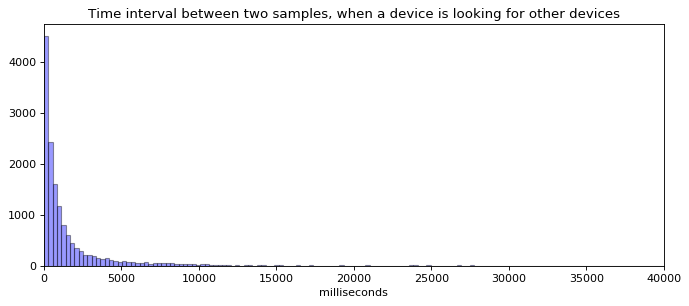

2009.0224628961091


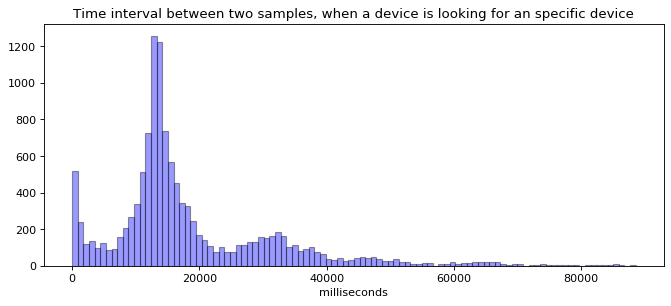

18515.066417668073


In [8]:
# plt.hist(mean_dif1,5,facecolor='blue', alpha=0.5)
plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(mean_dif1, hist=True, kde=False, 
             bins=int(300), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title("Time interval between two samples, when a device is looking for other devices")
plt.xlabel('milliseconds')
plt.xlim(0,40000)
plt.show()

plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(mean_dif2, hist=True, kde=False, norm_hist=False,
             bins=int(100), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title("Time interval between two samples, when a device is looking for an specific device")
plt.xlabel('milliseconds')
plt.show()
mean_dif = np.mean(mean_dif2)
print(mean_dif)

In [9]:
i = 0
data = pd.DataFrame()
while True:
    try:
        start_date,end_date,interval,positions = load_json_experiments(i)
    except:
        break
    for device1 in load_json_devices():
        for device2 in load_json_devices():
            if device1['id'] == device2['id']: continue
            data = data.append(handle_data(dataBT,start_date,end_date,device1['id'],device2 = device2['id'],\
                                           f = weighted_moving_average_filter,factor = mean_dif))
    i = i+1

#Getting the max_rssi_values scanned from a device, when 


Max:  OnePlus 6 -45.31459472944824
Min:  OnePlus 6 -73.05107089557801
Max:  Motorola -49.10621467460143
Min:  Motorola -76.72658374812919
Max:  Nexus 6 -53.141747683267546
Min:  Nexus 6 -81.4364087596173
Max:  Lenovo Tablet -41.0
Min:  Lenovo Tablet -73.84638512410223
Max:  OnePlus 3 -47.122622997821445
Min:  OnePlus 3 -76.01975841795425


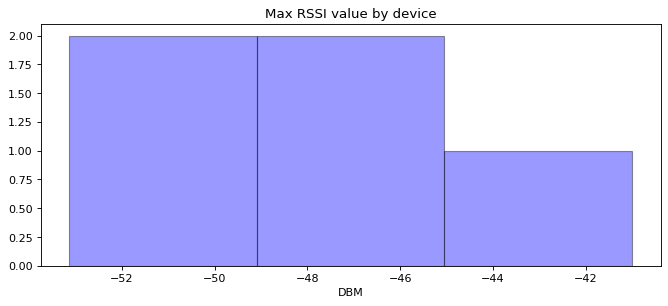

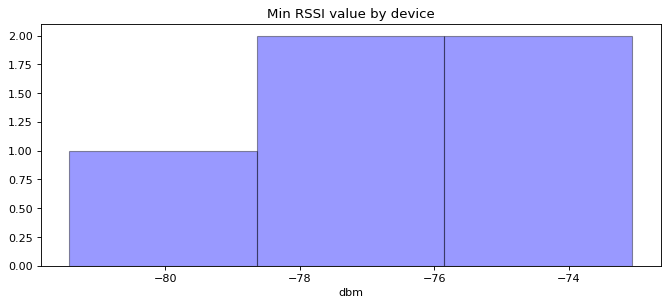

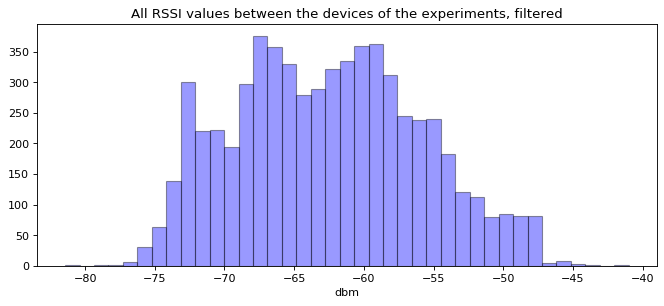

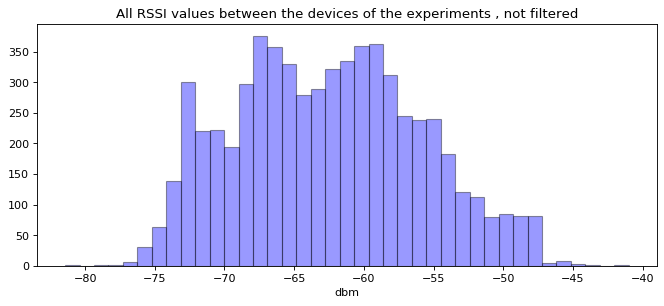

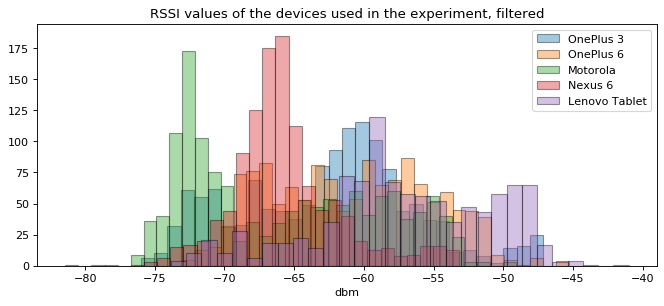

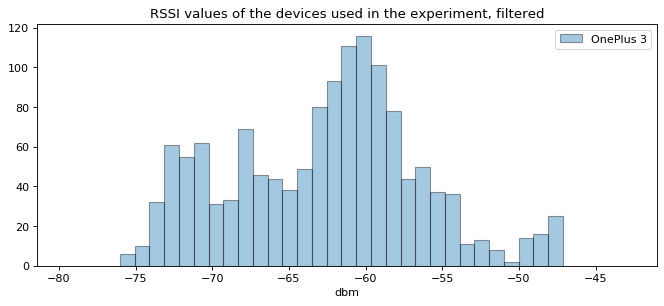

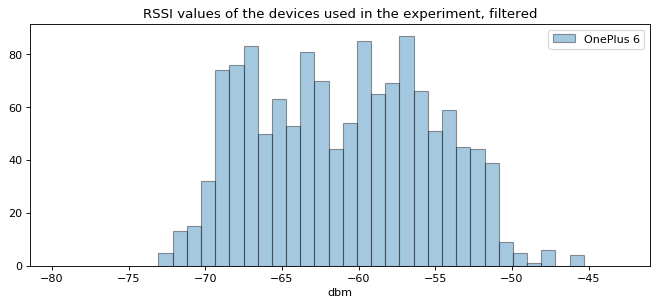

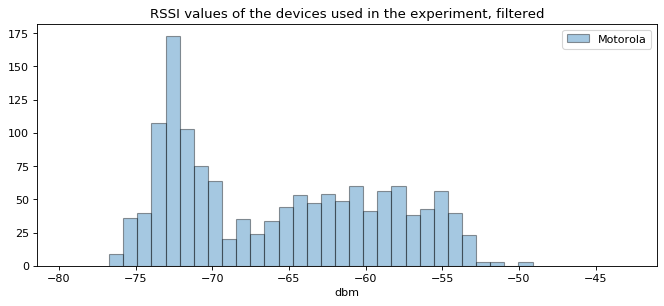

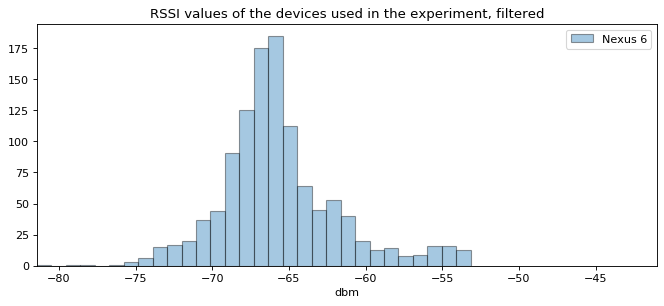

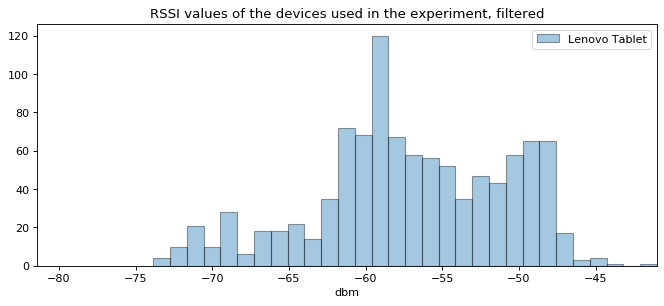

In [22]:
max_rssi = []
min_rssi = []
for device in data.ID2.unique():
    rssi_vals = data[data.ID2 == device].rssi_filtered.values
    max_rssi.append(max(rssi_vals))
    print("Max: ",get_device_name(device),max(rssi_vals))
    print("Min: ",get_device_name(device),min(rssi_vals))
    
    min_rssi.append(min(rssi_vals))
    
 #The maximum RSSI value when a device from the experiment is seen   
plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(max_rssi, hist=True, kde=False, norm_hist=False,
            color = 'blue', hist_kws={'edgecolor':'black'})
plt.title("Max RSSI value by device")
plt.xlabel('DBM')
plt.show()

#The minimum RSSI value when a device from the experiment is seen   
plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(min_rssi, hist=True, kde=False, norm_hist=False,
            color = 'blue', hist_kws={'edgecolor':'black'})
plt.title("Min RSSI value by device")
plt.xlabel('dbm')
plt.show()

#How the different devices of the experiments have been seen

plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(data.rssi_filtered.values, hist=True, kde=False, norm_hist=False,
            color = 'blue', hist_kws={'edgecolor':'black'})
plt.title("All RSSI values between the devices of the experiments, filtered")
plt.xlabel('dbm')
plt.show()

plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(data.rssi_filtered.values, hist=True, kde=False, norm_hist=False,
            color = 'blue', hist_kws={'edgecolor':'black'})
plt.title("All RSSI values between the devices of the experiments , not filtered")
plt.xlabel('dbm')
plt.show()


#Histogram for every device
plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
for device in data.ID1.unique():
    sns.distplot(data[data.ID2 == device].rssi_filtered.values, hist=True, kde=False, norm_hist=False,
            hist_kws={'edgecolor':'black'}, bins = 30, label =get_device_name(device))
    plt.title("RSSI values of the devices used in the experiment, filtered")
plt.xlabel('dbm')
plt.legend(loc = 'best')
plt.show()



for device in data.ID1.unique():
    plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    sns.distplot(data[data.ID2 == device].rssi_filtered.values, hist=True, kde=False, norm_hist=False,
            hist_kws={'edgecolor':'black'}, bins = 30, label =get_device_name(device))
    plt.title("RSSI values of the devices used in the experiment, filtered")
    plt.xlabel('dbm')
    plt.legend(loc = 'best')
    plt.xlim(min(min_rssi),max(max_rssi))
    plt.show()


In [170]:
n = 0
start_date,end_date,interval,positions = load_json_experiments(n)
devices = get_allowed_tuples(n)
data = pd.DataFrame()
for device1,device2 in list(devices):
    data1 = handle_data(dataBT,start_date,end_date,device1,device2,f = weighted_moving_average_filter,factor = mean_dif)
    data2 = handle_data(dataBT,start_date,end_date,device2,device1,f = weighted_moving_average_filter, factor = mean_dif)
    data = data.append(data1)
    data = data.append(data2)
data = add_devices_positions(data,positions,start_date,end_date)
data = add_devices_real_distances(data,positions,start_date,end_date,n)
data = data.drop_duplicates()
robot = get_id_robot(n)


Device OnePlus 3 -50.249656768003156 2.788599392874223
-50.249656768003156 2.788599392874223
Device OnePlus 3 -56.78888531762783 2.0808533046252564
-56.78888531762783 2.0808533046252564


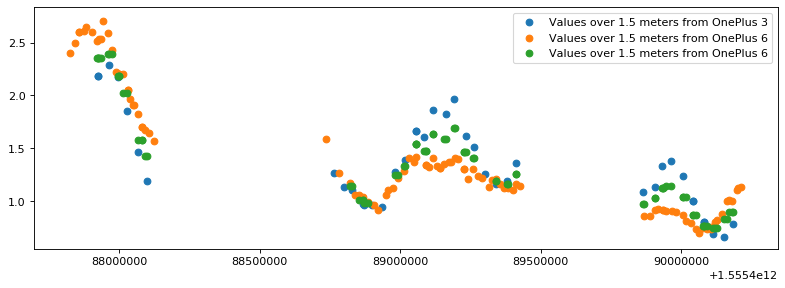

Device Motorola -56.24031229999314 1.4292628693396747
-56.24031229999314 1.4292628693396747
Device Motorola -58.63304198344505 1.5643516674178144
-58.63304198344505 1.5643516674178144


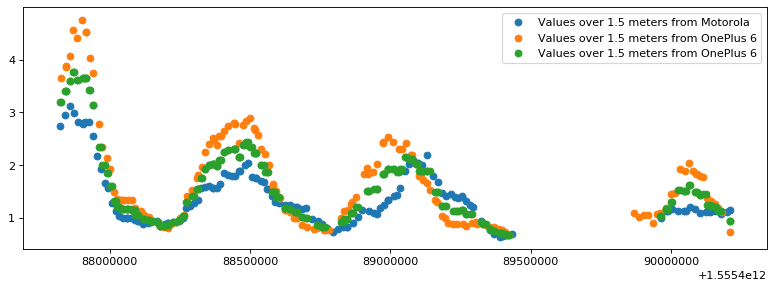

Device Nexus 6 -63.48385849645949 3.898083069911393
-63.48385849645949 3.898083069911393
Device Nexus 6 -62.49416411771115 4.261843820489949
-62.49416411771115 4.261843820489949


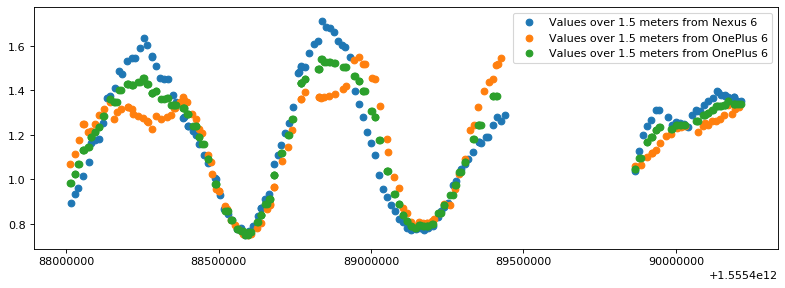

Device Lenovo Tablet -60.44476695105325 2.4790609406799575
-60.44476695105325 2.4790609406799575
Device Lenovo Tablet -55.68049046876773 2.493722514345133
-55.68049046876773 2.493722514345133


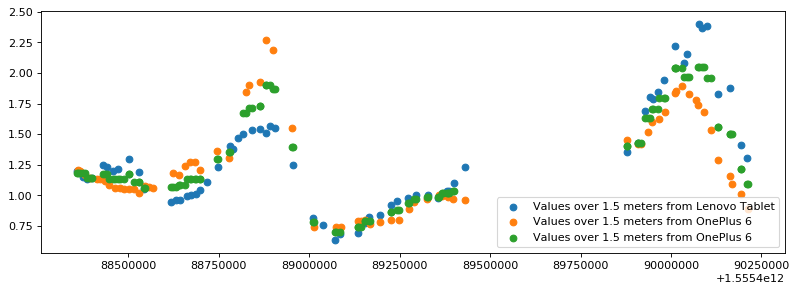

In [192]:
for device in data.ID1.unique():
    if device == robot: continue
    d1 = data[(data.ID1 == device) & (data.ID2 ==robot)]
    d2 = data[(data.ID2 == device) & (data.ID1 ==robot)]
    val1 = is_under_close_distance(d1)
    val2 = is_under_close_distance(d2)
    plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
    d1 = add_calculated_distance_by_one_device(d1,device)
    d2 = add_calculated_distance_by_one_device(d2,device)
    d3 = add_calculated_distance_by_two_devices(d1.append(d2),device,robot)
    plt.scatter(d1.milliseconds,d1.calculated_distance, \
                label = "Values over 1.5 meters from " + get_device_name(device) )
    plt.scatter(d2.milliseconds,d2.calculated_distance, \
                label = "Values over 1.5 meters from " + get_device_name(robot))
    plt.scatter(d3.milliseconds,d3.mean_distance, \
                label = "Values over 1.5 meters from " + get_device_name(robot))
    plt.legend(loc = 'best')
    plt.show()

OnePlus 3 seen Motorola in robot
-55.372732894874204 2
-55.62902649374004 2


/home/hugo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


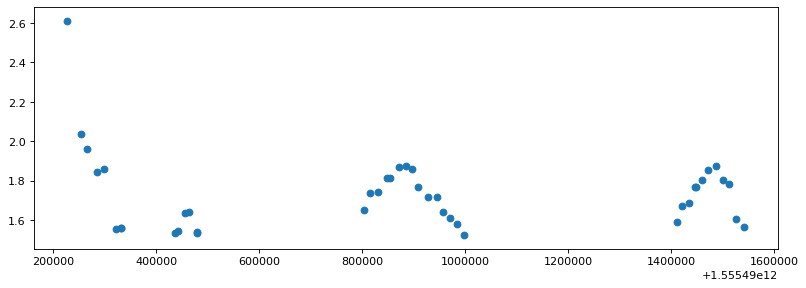

OnePlus 6 seen Motorola in robot
-56.32317155629079 2
-55.62902649374004 2


/home/hugo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


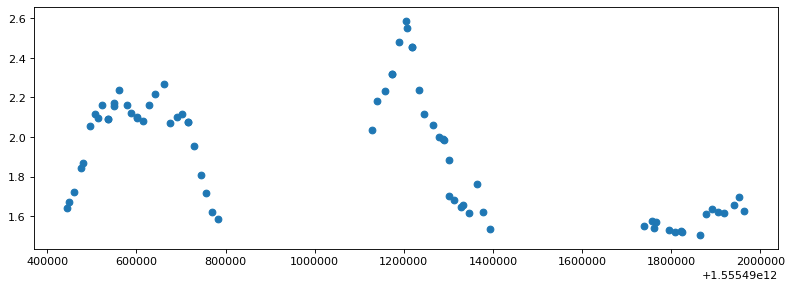

Nexus 6 seen Motorola in robot
-71.51923046173806 2
-55.62902649374004 2


/home/hugo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


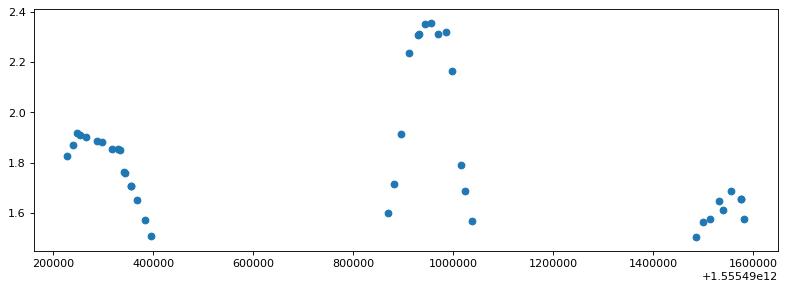

Lenovo Tablet seen Motorola in robot
-60.206940796986984 2
-55.62902649374004 2


/home/hugo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


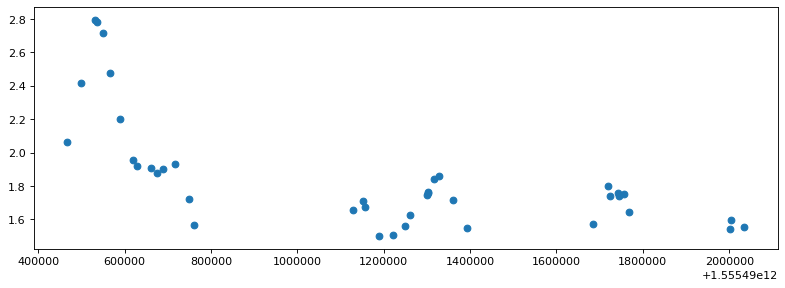

In [156]:
for device in data.ID1.unique():
        if device == robot: continue
        print(get_device_name(device) + " seen " + get_device_name(robot) + " in robot" )
        d1 = data[(data.ID1 == device) & (data.ID2 ==robot)]
        d2 = data[(data.ID2 == device) & (data.ID1 ==robot)]
        val1 = is_under_close_distance(d1)
        val2 = is_under_close_distance(d1.append(d2))
        d3 = add_calculated_distance_by_one_device(d2,robot)
        d4 = add_calculated_distance_by_two_devices(data,device,robot,mean_dif)[data.ID1 == robot]
        plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
#         plt.scatter(d2.milliseconds,d2.rssi_filtered)
#         plt.scatter(d1[d1.rssi_filtered > val1].milliseconds,d1[d1.rssi_filtered > val1].rssi_filtered,\
#                     label ="Data from 1 device")
        plt.scatter(d3[d3['calculated_distance'] > 1.5].milliseconds,d3[d3['calculated_distance'] > 1.5].calculated_distance, label = "Values over 1.5 meters")
#         plt.scatter(d4[d4['mean_distance'] > 1.5].milliseconds,d4[d4['mean_distance'] > 1.5].mean_distance, label = "Values over 1.5 meters")
#         n_lines = d1[d1.distance <= 1.5].milliseconds.values
#         for t in n_lines:
#             plt.axvline(t, color='k', linestyle='--')
#         plt.legend(loc = 'best')
        plt.show()

In [12]:
devices = data.ID1.unique()
robot = get_id_robot(2)
for device in devices:
    plot_custom_distance_by_time(data,device,2)

NameError: name 'min_distance' is not defined

In [ ]:

start_date,end_date,interval,positions = load_json_experiments(0)
devices = get_allowed_tuples(0)

for device1,device2 in list(devices):
    data1 = handle_data(dataBT,start_date,end_date,device1,device2)
    data2 = handle_data(dataBT,start_date,end_date,device2,device1)
    plot_rssi_by_time(data1,data2,device1,device2,interval)

In [ ]:

start_date,end_date,interval,positions = load_json_experiments(1)




In [ ]:
start_date,end_date,interval,positions = load_json_experiments(0)
devices = get_allowed_tuples(0)

for device1,device2 in list(devices):
    data1 = handle_data(dataBT,start_date,end_date,device1,device2)
    data2 = handle_data(dataBT,start_date,end_date,device2,device1)
    plot_rssi_by_time(data1,data2,device1,device2,interval)

In [ ]:
start_date,end_date,interval,positions = load_json_experiments(2)
devices = get_allowed_tuples(2)

for device1,device2 in list(devices):
    data1 = handle_data(dataBT,start_date,end_date,device1,device2)
    data2 = handle_data(dataBT,start_date,end_date,device2,device1)
    plot_rssi_by_time(data1,data2,device1,device2,interval)